# edges - Biodiversity, GLAM

0. Load data
1. Spatial Overlay: Intersect country boundaries with WWF ecoregions
2. Weight Calculation: Compute the percentage of each country occupied by each ecoregion
3. CF Matching: Merge Scherer et al. CFs based on eco_id
4. Output Generation: Creates a structured dataset ready for edges integration

In [1]:
import geopandas as gpd
import pandas as pd
import json
from collections import defaultdict
import country_converter as coco

# 0. Load data

### GLAM CF

https://zenodo.org/records/10114493

In [2]:
cfs_country = pd.read_csv("data/CF_domain_country.csv", encoding='latin1')
cfs_country.head()

,objectid,iso3cd,romnam,m49code,species_group,kingdom,habitat_id,habitat,CF_occ_avg_reg,CF_occ_avg_reg_rsd,...,CF_tra_avg_reg,CF_tra_avg_reg_rsd,CF_tra_avg_glo,CF_tra_avg_glo_rsd,CF_tra_mar_reg,CF_tra_mar_reg_rsd,CF_tra_mar_glo,CF_tra_mar_glo_rsd,quality_reg,quality_glo
0,1,AFG,Afghanistan,4,Eukaryota,NaN,2,Cropland_Intense,5.040459e-12,1.196734,...,1.722747e-09,1.431179,1.458811e-13,0.821610,5.013183e-09,1.356573,4.022789e-13,1.007625,proxy_partial,proxy_partial
1,1,AFG,Afghanistan,4,Eukaryota,NaN,3,Cropland_Light,4.039286e-12,1.157759,...,1.386000e-09,1.398384,1.268238e-13,0.810365,4.399628e-09,1.366675,3.681558e-13,1.027124,proxy_partial,proxy_partial
2,1,AFG,Afghanistan,4,Eukaryota,NaN,4,Cropland_Minimal,2.660704e-12,0.743908,...,8.131471e-10,0.881651,1.034815e-13,0.514989,3.275697e-09,1.549327,3.311098e-13,1.101810,original,original
3,1,AFG,Afghanistan,4,Eukaryota,NaN,5,Managed_forest_Intense,1.991685e-12,4.485955,...,6.965237e-10,4.842820,5.372177e-14,0.903259,8.736721e-10,4.985603,6.259734e-14,1.092102,original,original
4,1,AFG,Afghanistan,4,Eukaryota,NaN,6,Managed_forest_Light,7.370482e-13,2.869926,...,2.592714e-10,3.054855,3.250299e-14,2.224495,3.531856e-10,2.938292,4.830438e-14,2.479552,original,original


In [3]:
cfs = pd.read_csv("data/CF_domain.csv", encoding='latin1')
cfs.head()

,realm,biome,eco_id,eco_name,species_group,kingdom,habitat_id,habitat,CF_occ_avg_reg,CF_occ_avg_glo,CF_occ_mar_reg,CF_occ_mar_glo,CF_tra_avg_reg,CF_tra_avg_glo,CF_tra_mar_reg,CF_tra_mar_glo,quality_reg,quality_glo
0,AA,1,10101,Admiralty Islands lowland rain forests,Eukaryota,NaN,2,Cropland_Intense,5.109107e-11,1.010561e-14,7.646151e-11,1.537769e-14,9.039375e-09,1.831696e-12,1.376904e-08,2.846777e-12,proxy_type,proxy_gep
1,AA,1,10101,Admiralty Islands lowland rain forests,Eukaryota,NaN,3,Cropland_Light,4.094242e-11,9.490260e-15,6.150386e-11,1.447075e-14,7.289233e-09,1.725578e-12,1.115113e-08,2.688043e-12,proxy_type,proxy_gep
2,AA,1,10101,Admiralty Islands lowland rain forests,Eukaryota,NaN,4,Cropland_Minimal,2.861085e-11,5.351698e-15,4.276731e-11,8.137165e-15,5.051991e-09,9.688271e-13,7.684749e-09,1.504360e-12,proxy_type,proxy_gep
3,AA,1,10101,Admiralty Islands lowland rain forests,Eukaryota,NaN,5,Managed_forest_Intense,1.509520e-10,3.167896e-14,1.547415e-10,3.230867e-14,2.290059e-08,4.961487e-12,2.346978e-08,5.059342e-12,proxy_intensity,proxy_gep
4,AA,1,10101,Admiralty Islands lowland rain forests,Eukaryota,NaN,6,Managed_forest_Light,6.707070e-11,1.021026e-14,6.892013e-11,1.043147e-14,1.006374e-08,1.584641e-12,1.033925e-08,1.618621e-12,original,proxy_partial


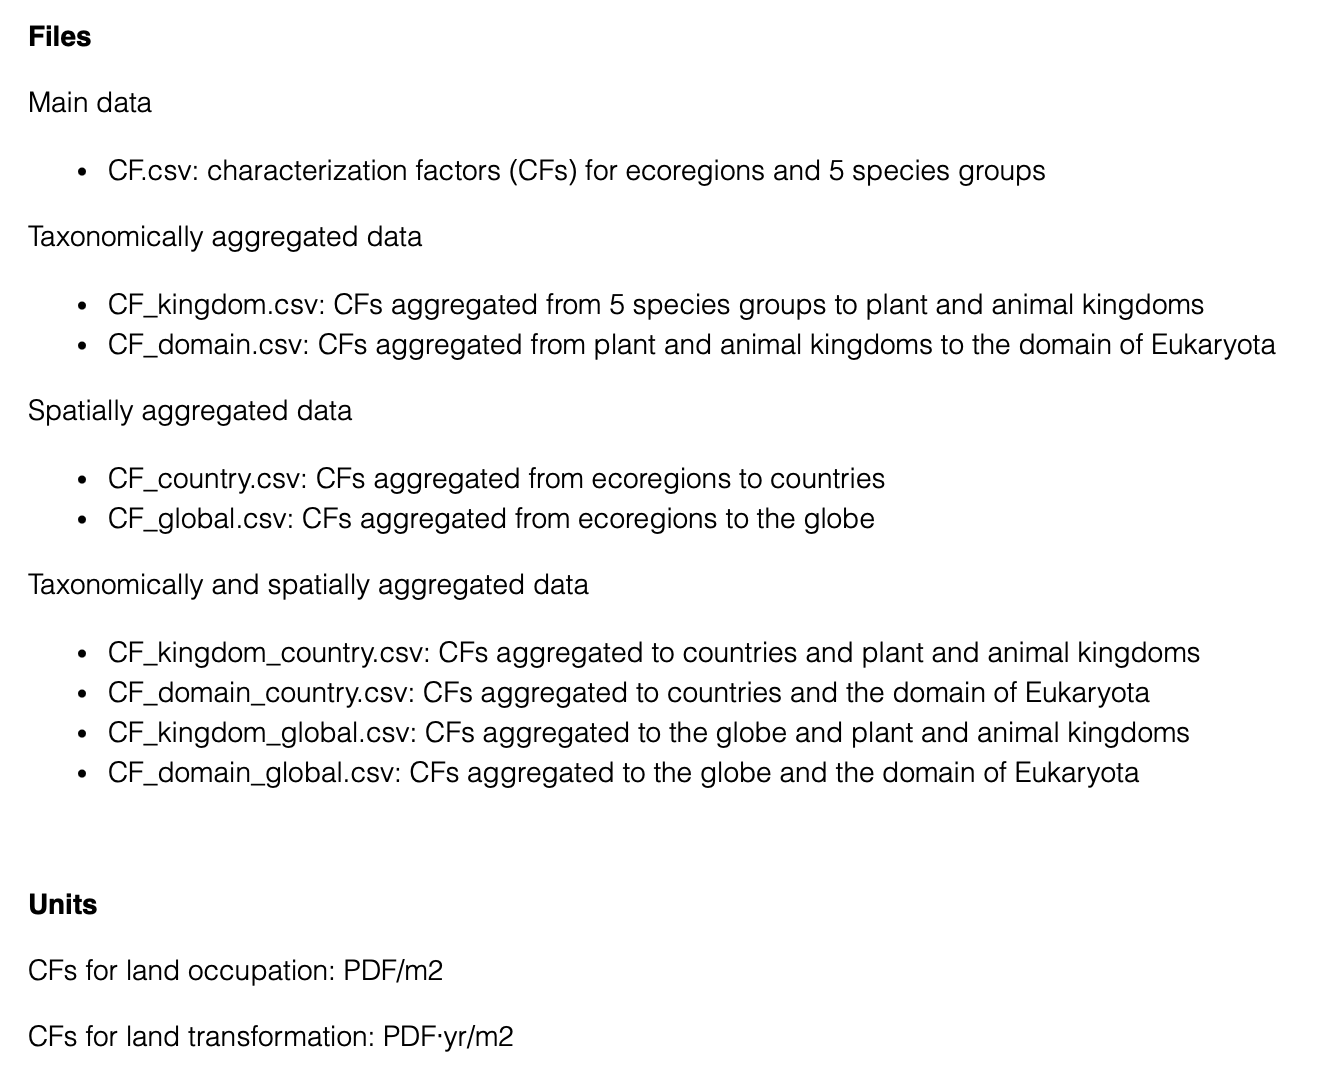

# Ecoregions

https://www.worldwildlife.org/publications/terrestrial-ecoregions-of-the-world

In [4]:
ecoregions = gpd.read_file("data/official/wwf_terr_ecos.shp")
# Ensure all are in the same CRS (WGS84)
ecoregions = ecoregions.to_crs("EPSG:4326")
# Create eco_id in ecoregions to match with CFs (from float to int)
ecoregions['eco_id'] = ecoregions['ECO_ID'].astype(int)

In [5]:
print(ecoregions.head())
print(ecoregions.columns)

   OBJECTID          AREA  PERIMETER                                 ECO_NAME  \
0         1     29.802942      0.219  Northern Mesoamerican Pacific mangroves   
1         2     11.977824      0.193  Northern Mesoamerican Pacific mangroves   
2         3  77301.372760    111.954                     Sinaloan dry forests   
3         4    215.489182      1.274  Northern Mesoamerican Pacific mangroves   
4         5     19.639089      0.363  Northern Mesoamerican Pacific mangroves   

  REALM  BIOME  ECO_NUM   ECO_ID  ECO_SYM  GBL_STAT  ... G200_STAT  \
0    NT   14.0      4.0  61404.0    119.0       1.0  ...       0.0   
1    NT   14.0      4.0  61404.0    119.0       1.0  ...       0.0   
2    NT    2.0     28.0  60228.0     98.0       1.0  ...       1.0   
3    NT   14.0      4.0  61404.0    119.0       1.0  ...       0.0   
4    NT   14.0      4.0  61404.0    119.0       1.0  ...       0.0   

   Shape_Leng  Shape_Area  area_km2  eco_code  PER_area  PER_area_1  \
0    0.219475    0.00

### Countries

https://www.naturalearthdata.com/downloads/10m-cultural-vectors/

We use map units, as we prefer, for example, to distinguish overseas regions of France.

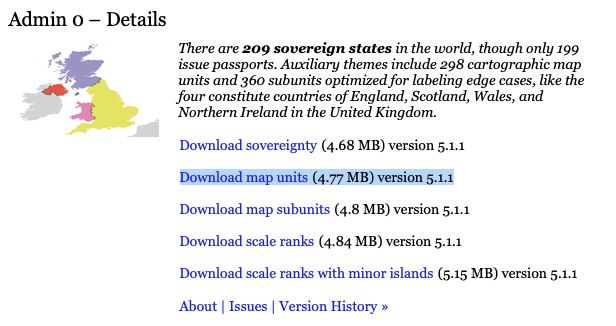

In [6]:
countries = gpd.read_file("data/ne_10m_admin_0_map_units/ne_10m_admin_0_map_units.shp")
# Ensure all are in the same CRS (WGS84)
countries = countries.to_crs("EPSG:4326")

In [7]:
print(f"Loaded {len(ecoregions)} ecoregions")
print(f"Loaded {len(countries)} countries")
print(f"Loaded {len(cfs)} CF records")

Loaded 14458 ecoregions
Loaded 298 countries
Loaded 12375 CF records


In [8]:
countries_projected = countries.to_crs("ESRI:54009")
countries['area_km2'] = countries_projected.geometry.area / 1e6
country_areas = countries.set_index('ISO_A3')['area_km2'].to_dict()
country_areas

{'IDN': 1892366.613635288,
 'MYS': 330072.24215046293,
 'CHL': 738017.590869393,
 'BOL': 1092895.4562693113,
 'PER': 1298027.443530577,
 'ARG': 2789349.0983146913,
 '-99': 0.09835497858727028,
 'CYP': 5407.60004640422,
 'IND': 3165389.005757481,
 'CHN': 9394400.41201053,
 'ISR': 22169.56057498407,
 'LBN': 10029.577474047659,
 'ETH': 1134602.9167184194,
 'SSD': 630939.4700157284,
 'KEN': 589637.1364584223,
 'MWI': 120116.51247629491,
 'TZA': 945157.8495601225,
 'GUF': 83738.9094930474,
 'SUR': 146090.75973087366,
 'GUY': 212614.39664711035,
 'MAR': 593756.8490366903,
 'ESH': 90899.97464797733,
 'CRI': 51475.48962436054,
 'NIC': 129466.58487113452,
 'COG': 347204.11493899877,
 'COD': 2340650.457490021,
 'BTN': 40578.24402617017,
 'UKR': 571456.3452909099,
 'BLR': 207094.82834368103,
 'NAM': 826670.8536212448,
 'ZAF': 1224180.4658882907,
 'SYR': 186101.43391646657,
 'MAF': 68.65327843456788,
 'SXM': 23.485656908999538,
 'OMN': 312789.2606449181,
 'UZB': 448182.44851229584,
 'KAZ': 2712412

There are 49 unique ecoregions in Brazil.


/var/folders/cr/vqjj3__922921yq2j83lmk700000gn/T/ipykernel_29140/4070622865.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_ecos))


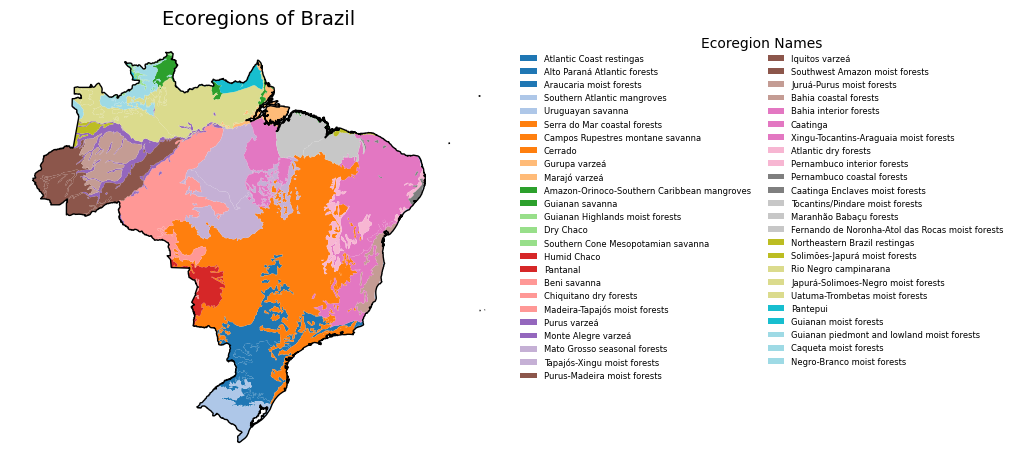

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load and prepare data
ecoregions = gpd.read_file("data/official/wwf_terr_ecos.shp").to_crs("EPSG:4326")
ecoregions["eco_id"] = ecoregions["ECO_ID"].astype(int)
countries = gpd.read_file("data/ne_10m_admin_0_map_units/ne_10m_admin_0_map_units.shp").to_crs("EPSG:4326")

# Select the country
country = countries[countries["NAME"] == "Brazil"]
eco_in_country = gpd.clip(ecoregions, country)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
country.boundary.plot(ax=ax, color="black", linewidth=1)

# Unique ecoregions and colors
unique_ecos = eco_in_country["ECO_NAME"].unique()
print(f"There are {len(unique_ecos)} unique ecoregions in Brazil.")
cmap = plt.cm.get_cmap("tab20", len(unique_ecos))

# Plot each ecoregion separately to control legend entries
for i, eco in enumerate(unique_ecos):
    subset = eco_in_country[eco_in_country["ECO_NAME"] == eco]
    subset.plot(ax=ax, color=cmap(i), edgecolor="none", label=eco)

# Custom legend with two columns
legend_elements = [Patch(facecolor=cmap(i), edgecolor="none", label=eco) for i, eco in enumerate(unique_ecos)]
ax.legend(
    handles=legend_elements,
    title="Ecoregion Names",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=False,
    ncol=2,
    fontsize=6
)

ax.set_title("Ecoregions of Brazil", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.savefig("map_afg.png", bbox_inches="tight")
plt.show()



# 1. Spatial overlay

In [10]:
overlay = gpd.overlay(countries, ecoregions, how='intersection')

# 2. Weight Calculation

In [11]:
# Calculate area of each intersection in km2
# Use an equal-area projection to get accurate areas
overlay_projected = overlay.to_crs("ESRI:54009")  # World Mollweide
overlay['intersection_area_km2'] = overlay_projected.geometry.area / 1e6  # Convert m² to km²

In [12]:
# Calculate the percentage of each ecoregion within each country
country_ecoregion = overlay.groupby(['ISO_A3', 'eco_id']).agg({
    'intersection_area_km2': 'sum',
    'NAME': 'first',  # Country name
    'ECO_NAME': 'first'  # Ecoregion name
}).reset_index()

In [13]:
# Calculate total country area for percentage calculation
country_totals = country_ecoregion.groupby('ISO_A3')['intersection_area_km2'].sum()
country_ecoregion = country_ecoregion.merge(
    country_totals.rename('country_total_km2'),
    left_on='ISO_A3',
    right_index=True
)

In [14]:
# Calculate weight factor (% of country area occupied by each ecoregion)
country_ecoregion['weight_factor'] = (
    country_ecoregion['intersection_area_km2'] / 
    country_ecoregion['country_total_km2']
)

# 3. CF matching

### Dataframe matching

In [15]:
country_ecoregion_cfs = country_ecoregion.merge(
    cfs,
    on='eco_id',
    how='left'
)

In [16]:
output_cols = [
    'ISO_A3',
    'NAME',
    'eco_id',
    'ECO_NAME',
    'intersection_area_km2',
    'weight_factor',
    'habitat_id',
    'habitat',
    'CF_occ_avg_reg',
    'CF_occ_avg_glo',
    'CF_occ_mar_reg',
    'CF_occ_mar_glo',
    'CF_tra_avg_reg',
    'CF_tra_avg_glo',
    'CF_tra_mar_reg',
    'CF_tra_mar_glo',
    'quality_reg',
    'quality_glo'
]

final_output = country_ecoregion_cfs[output_cols].copy()

# Rename columns for clarity
final_output.columns = [
    'country_iso',
    'country_name',
    'ecoregion_id',
    'ecoregion_name',
    'area_km2',
    'weight_factor',
    'habitat_id',
    'habitat_type',
    'cf_occupation_avg_regional',
    'cf_occupation_avg_global',
    'cf_occupation_marginal_regional',
    'cf_occupation_marginal_global',
    'cf_transformation_avg_regional',
    'cf_transformation_avg_global',
    'cf_transformation_marginal_regional',
    'cf_transformation_marginal_global',
    'quality_regional',
    'quality_global'
]

In [17]:
final_output = final_output.sort_values(
    ['country_name', 'ecoregion_id', 'habitat_id'],
    ascending=True
)

In [18]:
final_output.to_csv("output/country_ecoregion_cfs_scherer.csv", index=False)
final_output.head()

,country_iso,country_name,ecoregion_id,ecoregion_name,area_km2,weight_factor,habitat_id,habitat_type,cf_occupation_avg_regional,cf_occupation_avg_global,cf_occupation_marginal_regional,cf_occupation_marginal_global,cf_transformation_avg_regional,cf_transformation_avg_global,cf_transformation_marginal_regional,cf_transformation_marginal_global,quality_regional,quality_global
1216,AFG,Afghanistan,-9999,Rock and Ice,733.127568,0.001139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1217,AFG,Afghanistan,40502,Western Himalayan subalpine conifer forests,172.624661,0.000268,2.0,Cropland_Intense,5.566279e-12,1.218521e-15,1.053651e-11,2.326160e-15,3.180418e-09,7.093887e-13,6.025718e-09,1.355258e-12,original,original
1218,AFG,Afghanistan,40502,Western Himalayan subalpine conifer forests,172.624661,0.000268,3.0,Cropland_Light,4.504786e-12,1.068908e-15,8.580580e-12,2.050479e-15,2.591388e-09,6.263671e-13,4.940361e-09,1.202281e-12,original,original
1219,AFG,Afghanistan,40502,Western Himalayan subalpine conifer forests,172.624661,0.000268,4.0,Cropland_Minimal,3.107342e-12,6.619554e-16,5.870152e-12,1.261481e-15,1.771590e-09,3.844709e-13,3.349742e-09,7.332721e-13,proxy_intensity,proxy_intensity
1220,AFG,Afghanistan,40502,Western Himalayan subalpine conifer forests,172.624661,0.000268,5.0,Managed_forest_Intense,3.101687e-12,6.339597e-16,5.833646e-12,1.203940e-15,1.760432e-09,3.663778e-13,3.313784e-09,6.963817e-13,proxy_intensity,proxy_intensity


In [19]:
# Get unique ecoregions per country and sum their weights
spain_check = final_output[final_output['country_iso'] == 'ESP'].groupby('ecoregion_id')['weight_factor'].first().sum()
spain_check

1.0

### Matching habitats to ecoinvent

Matching done according to: https://doi.org/10.1007/s11367-021-02003-y

In [20]:
# import bw2data as bd
# import bw2io as bi
# bd.projects.set_current("bw25_ei311")
# bf = bd.Database('biosphere')
# sorted([m["name"] for m in bf if "Transformation, from" in m["name"]])

In [21]:
occupation_flows = {
    'Occupation, annual crop': 'Cropland_Intense',
    'Occupation, annual crop, flooded crop': 'Cropland_Intense',
    'Occupation, annual crop, greenhouse': 'Urban_Light',
    'Occupation, annual crop, irrigated': 'Cropland_Intense',
    'Occupation, annual crop, irrigated, extensive': 'Cropland_Light',
    'Occupation, annual crop, irrigated, intensive': 'Cropland_Intense',
    'Occupation, annual crop, non-irrigated': 'Cropland_Intense',
    'Occupation, annual crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Occupation, annual crop, non-irrigated, intensive': 'Cropland_Intense',
    'Occupation, arable land, unspecified use': 'Cropland_Intense',
    # 'Occupation, arable, conservation tillage (obsolete)': '',
    # 'Occupation, arable, conventional tillage (obsolete)': '',
    # 'Occupation, arable, reduced tillage (obsolete)': '',
    # 'Occupation, bare area (non-use)': '',
    'Occupation, construction site': 'Urban_Intense',
    'Occupation, cropland fallow (non-use)': 'Cropland_Minimal',
    'Occupation, dump site': 'Urban_Intense',
    'Occupation, field margin/hedgerow': 'Cropland_Minimal',
    'Occupation, forest, extensive': 'Pasture_Light',
    'Occupation, forest, intensive': 'Managed_forest_Intense',
    'Occupation, forest, primary (non-use)': 'Managed_forest_Minimal',
    'Occupation, forest, secondary (non-use)': 'Pasture_Light',
    'Occupation, forest, unspecified': 'Managed_forest_Intense',
    'Occupation, grassland, natural (non-use)': 'Pasture_Minimal',
    'Occupation, grassland, natural, for livestock grazing': 'Pasture_Minimal',
    'Occupation, heterogeneous, agricultural': 'Cropland_Minimal',
    'Occupation, industrial area': 'Urban_Intense',
    # 'Occupation, inland waterbody, unspecified': '',
    # 'Occupation, lake, artificial': '',
    # 'Occupation, lake, natural (non-use)': '',
    'Occupation, mineral extraction site': 'Urban_Intense',
    'Occupation, pasture, man made': 'Pasture_Intense',
    'Occupation, pasture, man made, extensive': 'Pasture_Light',
    'Occupation, pasture, man made, intensive': 'Pasture_Intense',
    'Occupation, permanent crop': 'Cropland_Intense',
    'Occupation, permanent crop, irrigated': 'Cropland_Intense',
    'Occupation, permanent crop, irrigated, extensive': 'Cropland_Light',
    'Occupation, permanent crop, irrigated, intensive': 'Cropland_Intense',
    'Occupation, permanent crop, non-irrigated': 'Cropland_Intense',
    'Occupation, permanent crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Occupation, permanent crop, non-irrigated, intensive': 'Cropland_Intense',
    # 'Occupation, river, artificial': '',
    # 'Occupation, river, natural (non-use)': '',
    # 'Occupation, seabed, drilling and mining': '',
    # 'Occupation, seabed, infrastructure': '',
    # 'Occupation, seabed, natural (non-use)': '',
    # 'Occupation, seabed, unspecified': '',
    'Occupation, shrub land, sclerophyllous': 'Managed_forest_Minimal',
    # 'Occupation, snow and ice (non-use)': '',
    'Occupation, traffic area, rail network': 'Urban_Intense',
    'Occupation, traffic area, rail/road embankment': 'Urban_Light',
    'Occupation, traffic area, road network': 'Urban_Intense',
    'Occupation, unspecified': 'Urban_Intense',
    'Occupation, unspecified, natural (non-use)': 'Pasture_Minimal',
    'Occupation, urban, continuously built': 'Urban_Intense',
    'Occupation, urban, discontinuously built': 'Urban_Light',
    'Occupation, urban, green area': 'Urban_Minimal',
    'Occupation, urban/industrial fallow (non-use)': 'Urban_Light',
    # 'Occupation, wetland, coastal (non-use)': '',
    # 'Occupation, wetland, inland (non-use)': '',
}

In [22]:
transformation_to_flows = {
    'Transformation, to annual crop': 'Cropland_Intense',
    'Transformation, to annual crop, flooded crop': 'Cropland_Intense',
    'Transformation, to annual crop, greenhouse': 'Urban_Light',
    'Transformation, to annual crop, irrigated': 'Cropland_Intense',
    'Transformation, to annual crop, irrigated, extensive': 'Cropland_Light',
    'Transformation, to annual crop, irrigated, intensive': 'Cropland_Intense',
    'Transformation, to annual crop, non-irrigated': 'Cropland_Intense',
    'Transformation, to annual crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Transformation, to annual crop, non-irrigated, intensive': 'Cropland_Intense',
    'Transformation, to arable land, unspecified use': 'Cropland_Intense',
    # 'Transformation, to bare area (non-use)': '',
    'Transformation, to cropland fallow (non-use)': 'Cropland_Minimal',
    'Transformation, to dump site': 'Urban_Intense',
    'Transformation, to dump site, inert material landfill': 'Urban_Intense',
    'Transformation, to dump site, residual material landfill': 'Urban_Intense',
    'Transformation, to dump site, sanitary landfill': 'Urban_Intense',
    'Transformation, to dump site, slag compartment': 'Urban_Intense',
    'Transformation, to field margin/hedgerow': 'Cropland_Minimal',
    'Transformation, to forest, extensive': 'Managed_forest_Light',
    'Transformation, to forest, intensive': 'Managed_forest_Intense',
    'Transformation, to forest, primary (non-use)': 'Pasture_Minimal',
    'Transformation, to forest, secondary (non-use)': 'Managed_forest_Light',
    'Transformation, to forest, unspecified': 'Managed_forest_Intense',
    'Transformation, to grassland, natural (non-use)': 'Pasture_Minimal',
    'Transformation, to grassland, natural, for livestock grazing': 'Pasture_Minimal',
    'Transformation, to heterogeneous, agricultural': 'Cropland_Minimal',
    'Transformation, to industrial area': 'Urban_Intense',
    # 'Transformation, to inland waterbody, unspecified': '',
    # 'Transformation, to lake, artificial': '',
    # 'Transformation, to lake, natural (non-use)': '',
    'Transformation, to mineral extraction site': 'Urban_Intense',
    'Transformation, to pasture, man made': 'Pasture_Intense',
    'Transformation, to pasture, man made, extensive': 'Pasture_Light',
    'Transformation, to pasture, man made, intensive': 'Pasture_Intense',
    'Transformation, to permanent crop': 'Cropland_Intense',
    'Transformation, to permanent crop, irrigated': 'Cropland_Intense',
    'Transformation, to permanent crop, irrigated, extensive': 'Cropland_Light',
    'Transformation, to permanent crop, irrigated, intensive': 'Cropland_Intense',
    'Transformation, to permanent crop, non-irrigated': 'Cropland_Intense',
    'Transformation, to permanent crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Transformation, to permanent crop, non-irrigated, intensive': 'Cropland_Intense',
    # 'Transformation, to river, artificial': '',
    # 'Transformation, to river, natural (non-use)': '',
    # 'Transformation, to seabed, drilling and mining': '',
    # 'Transformation, to seabed, infrastructure': '',
    # 'Transformation, to seabed, natural (non-use)': '',
    # 'Transformation, to seabed, unspecified': '',
    'Transformation, to shrub land, sclerophyllous': 'Pasture_Minimal',
    # 'Transformation, to snow and ice (non-use)': '',
    'Transformation, to traffic area, rail network': 'Urban_Intense',
    'Transformation, to traffic area, rail/road embankment': 'Urban_Light',
    'Transformation, to traffic area, road network': 'Urban_Intense',
    'Transformation, to unknown': 'Urban_Intense', # Added - Matched to unspecified
    'Transformation, to unspecified': 'Urban_Intense',
    'Transformation, to unspecified, natural (non-use)': 'Pasture_Minimal',
    'Transformation, to urban, continuously built': 'Urban_Intense',
    'Transformation, to urban, discontinuously built': 'Urban_Light',
    'Transformation, to urban, green area': 'Urban_Minimal',
    'Transformation, to urban/industrial fallow (non-use)': 'Urban_Light',
    # 'Transformation, to wetland, coastal (non-use)': '',
    # 'Transformation, to wetland, inland (non-use)': '',   
}

In [23]:
transformation_from_flows = {
    'Transformation, from annual crop': 'Cropland_Intense',
    'Transformation, from annual crop, flooded crop': 'Cropland_Intense',
    'Transformation, from annual crop, greenhouse': 'Urban_Light',
    'Transformation, from annual crop, irrigated': 'Cropland_Intense',
    'Transformation, from annual crop, irrigated, extensive': 'Cropland_Light',
    'Transformation, from annual crop, irrigated, intensive': 'Cropland_Intense',
    'Transformation, from annual crop, non-irrigated': 'Cropland_Intense',
    'Transformation, from annual crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Transformation, from annual crop, non-irrigated, intensive': 'Cropland_Intense',
    'Transformation, from arable land, unspecified use': 'Cropland_Intense',
    # 'Transformation, from bare area (non-use)': '',
    'Transformation, from cropland fallow (non-use)': 'Cropland_Minimal',
    'Transformation, from dump site': 'Urban_Intense',
    'Transformation, from dump site, inert material landfill': 'Urban_Intense',
    'Transformation, from dump site, residual material landfill': 'Urban_Intense',
    'Transformation, from dump site, sanitary landfill': 'Urban_Intense',
    'Transformation, from dump site, slag compartment': 'Urban_Intense',
    'Transformation, from field margin/hedgerow': 'Cropland_Minimal',
    'Transformation, from forest, extensive': 'Managed_forest_Light',
    'Transformation, from forest, intensive': 'Managed_forest_Intense',
    'Transformation, from forest, primary (non-use)': 'Pasture_Minimal',
    'Transformation, from forest, secondary (non-use)': 'Managed_forest_Light',
    'Transformation, from forest, unspecified': 'Managed_forest_Intense',
    'Transformation, from grassland, natural (non-use)': 'Pasture_Minimal',
    'Transformation, from grassland, natural, for livestock grazing': 'Pasture_Minimal',
    'Transformation, from heterogeneous, agricultural': 'Cropland_Minimal',
    'Transformation, from industrial area': 'Urban_Intense',
    # 'Transformation, from inland waterbody, unspecified': '',
    # 'Transformation, from lake, artificial': '',
    # 'Transformation, from lake, natural (non-use)': '',
    'Transformation, from mineral extraction site': 'Urban_Intense',
    'Transformation, from pasture, man made': 'Pasture_Intense',
    'Transformation, from pasture, man made, extensive': 'Pasture_Light',
    'Transformation, from pasture, man made, intensive': 'Pasture_Intense',
    'Transformation, from permanent crop': 'Cropland_Intense',
    'Transformation, from permanent crop, irrigated': 'Cropland_Intense',
    'Transformation, from permanent crop, irrigated, extensive': 'Cropland_Light',
    'Transformation, from permanent crop, irrigated, intensive': 'Cropland_Intense',
    'Transformation, from permanent crop, non-irrigated': 'Cropland_Intense',
    'Transformation, from permanent crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Transformation, from permanent crop, non-irrigated, intensive': 'Cropland_Intense',
    # 'Transformation, from river, artificial': '',
    # 'Transformation, from river, natural (non-use)': '',
    # 'Transformation, from seabed, drilling and mining': '',
    # 'Transformation, from seabed, infrastructure': '',
    # 'Transformation, from seabed, natural (non-use)': '',
    # 'Transformation, from seabed, unspecified': '',
    'Transformation, from shrub land, sclerophyllous': 'Pasture_Minimal',
    # 'Transformation, from snow and ice (non-use)': '',
    'Transformation, from traffic area, rail network': 'Urban_Intense',
    'Transformation, from traffic area, rail/road embankment': 'Urban_Light',
    'Transformation, from traffic area, road network': 'Urban_Intense',
    'Transformation, from unknown': 'Urban_Intense', # Added - Matched to unspecified
    'Transformation, from unspecified': 'Urban_Intense',
    'Transformation, from unspecified, natural (non-use)': 'Pasture_Minimal',
    'Transformation, from urban, continuously built': 'Urban_Intense',
    'Transformation, from urban, discontinuously built': 'Urban_Light',
    'Transformation, from urban, green area': 'Urban_Minimal',
    'Transformation, from urban/industrial fallow (non-use)': 'Urban_Light',
    # 'Transformation, from wetland, coastal (non-use)': '',
    # 'Transformation, from wetland, inland (non-use)': '',   
}

# 4. JSON generation

In [24]:
cc = coco.CountryConverter()

In [25]:
def generate_occupation_json():
    """Generate JSON for occupation flows"""
    
    exchanges = []
    
    # Group by country and biosphere flow
    for flow_name, habitat_type in occupation_flows.items():
        
        # Get all countries
        countries_list = final_output['country_iso'].unique()
        
        for country in countries_list:
            # Get country-level CF from cfs_country
            country_cf_row = cfs_country[
                (cfs_country['iso3cd'] == country) &
                (cfs_country['habitat'] == habitat_type)
            ]
            
            # If no country-level CF available, skip this country-habitat combination
            if len(country_cf_row) == 0:
                continue
            
            # Get the country-level CF value
            country_cf_value = country_cf_row['CF_occ_avg_glo'].iloc[0]
            
            # Filter ecoregion data for uncertainty parameters
            country_data = final_output[
                (final_output['country_iso'] == country) &
                (final_output['habitat_type'] == habitat_type)
            ]
            
            if len(country_data) == 0:
                continue
            
            # Get unique ecoregions for uncertainty
            unique_ecoregions = country_data.drop_duplicates(subset=['ecoregion_id'])
            
            # Prepare uncertainty parameters from ecoregion data
            values = unique_ecoregions['cf_occupation_avg_global'].tolist()
            weights = unique_ecoregions['weight_factor'].tolist()
            
            # Get country area
            country_area = country_areas.get(country, 0)
            
            exchange = {
                "supplier": {
                    "name": flow_name,
                    "categories": ["natural resource", "land"],
                    "matrix": "biosphere"
                },
                "consumer": {
                    "location": cc.convert(names=country, to='ISO2'),
                    "matrix": "technosphere"
                },
                "value": float(country_cf_value),
                "weight": float(country_area),
                "uncertainty": {
                    "distribution": "discrete_empirical",
                    "parameters": {
                        "values": [float(v) for v in values],
                        "weights": [float(w) for w in weights]
                    }
                }
            }
            
            exchanges.append(exchange)
    
    output = {
        "name": "ecoinvent 3.10/3.11 - GLAM3 - Land occupation, biodiversity damage",
        "unit": "PDF.yr",
        "version": "0.1",
        "description": "Characterization factors for land occupation impacts on biodiversity, considering global species loss. Based on Scherer et al. 2023: https://doi.org/10.5281/zenodo.10114492",
        "strategies": [
            "map_exchanges",
            "map_aggregate_locations",
            "map_dynamic_locations",
            "map_contained_locations",
            "map_remaining_locations_to_global"
        ],
        "exchanges": exchanges
    }
    
    return output

In [26]:
def generate_transformation_json():
    """Generate JSON for transformation flows (from and to combined)"""
    
    exchanges = []
    
    # Process transformation FROM flows
    for flow_name, habitat_type in transformation_from_flows.items():
        
        countries_list = final_output['country_iso'].unique()
        
        for country in countries_list:
            # Get country-level CF from cfs_country
            country_cf_row = cfs_country[
                (cfs_country['iso3cd'] == country) &
                (cfs_country['habitat'] == habitat_type)
            ]
            
            if len(country_cf_row) == 0:
                continue
            
            # Get the country-level CF value for transformation
            country_cf_value = country_cf_row['CF_tra_avg_glo'].iloc[0]
            
            # Filter ecoregion data for uncertainty parameters
            country_data = final_output[
                (final_output['country_iso'] == country) &
                (final_output['habitat_type'] == habitat_type)
            ]
            
            if len(country_data) == 0:
                continue
            
            unique_ecoregions = country_data.drop_duplicates(subset=['ecoregion_id'])
            
            values = unique_ecoregions['cf_transformation_avg_global'].tolist()
            weights = unique_ecoregions['weight_factor'].tolist()
            
            country_area = country_areas.get(country, 0)
            
            exchange = {
                "supplier": {
                    "name": flow_name,
                    "categories": ["natural resource", "land"],
                    "matrix": "biosphere"
                },
                "consumer": {
                    "location": cc.convert(names=country, to='ISO2'),
                    "matrix": "technosphere"
                },
                "value": float(country_cf_value),
                "weight": float(country_area),
                "uncertainty": {
                    "distribution": "discrete_empirical",
                    "parameters": {
                        "values": [float(v) for v in values],
                        "weights": [float(w) for w in weights]
                    }
                }
            }
            
            exchanges.append(exchange)
    
    # Process transformation TO flows
    for flow_name, habitat_type in transformation_to_flows.items():        
        countries_list = final_output['country_iso'].unique()
        
        for country in countries_list:
            # Get country-level CF from cfs_country
            country_cf_row = cfs_country[
                (cfs_country['iso3cd'] == country) &
                (cfs_country['habitat'] == habitat_type)
            ]
            
            if len(country_cf_row) == 0:
                continue
            
            # Get the country-level CF value for transformation
            country_cf_value = country_cf_row['CF_tra_avg_glo'].iloc[0]
            
            # Filter ecoregion data for uncertainty parameters
            country_data = final_output[
                (final_output['country_iso'] == country) &
                (final_output['habitat_type'] == habitat_type)
            ]
            
            if len(country_data) == 0:
                continue
            
            unique_ecoregions = country_data.drop_duplicates(subset=['ecoregion_id'])
            
            values = unique_ecoregions['cf_transformation_avg_global'].tolist()
            weights = unique_ecoregions['weight_factor'].tolist()
            
            country_area = country_areas.get(country, 0)
            
            exchange = {
                "supplier": {
                    "name": flow_name,
                    "categories": ["natural resource", "land"],
                    "matrix": "biosphere"
                },
                "consumer": {
                    "location": cc.convert(names=country, to='ISO2'),
                    "matrix": "technosphere"
                },
                "value": float(country_cf_value),
                "weight": float(country_area),
                "uncertainty": {
                    "distribution": "discrete_empirical",
                    "parameters": {
                        "values": [float(v) for v in values],
                        "weights": [float(w) for w in weights]
                    }
                }
            }
            
            exchanges.append(exchange)
    
    output = {
        "name": "ecoinvent 3.10/3.11 - GLAM3 - Land transformation, biodiversity damage",
        "unit": "PDF.yr",
        "version": "0.1",
        "description": "Characterization factors for land transformation impacts on biodiversity, considering global species loss. Based on Scherer et al. 2023: https://doi.org/10.5281/zenodo.10114492",
        "strategies": [
            "map_exchanges",
            "map_aggregate_locations",
            "map_dynamic_locations",
            "map_contained_locations",
            "map_remaining_locations_to_global"
        ],
        "exchanges": exchanges
    }
    
    return output

In [ ]:
occupation_json = generate_occupation_json()
with open("output/GLAM3_biodiversity_occupation_average_eukaryota.json", "w") as f:
    json.dump(occupation_json, f, indent=2)

In [ ]:
transformation_json = generate_transformation_json()
with open("output/GLAM3_biodiversity_transformation_average_eukaryota.json", "w") as f:
    json.dump(transformation_json, f, indent=2)